---

<div align="center">

# Copyright and Credit Notice

**Jupyter Lab created by**

**Prof. Hyunglok Kim**

**Hydro AI Lab, GIST, South Korea**

Website: [hydroai.net](http://hydroai.net)

---

**Commercial Use Prohibited**

None of the materials may be used commercially. Please contact me if you plan to modify and use these materials for any educational purpose or research.

---
**Contact Information**

Prof. Hyunglok Kim  
Hydro AI Lab, GIST, South Korea  
Email: [hyunglokkim@gist.ac.kr](mailto:hyunglokkim@gist.ac.kr)

---

</div>

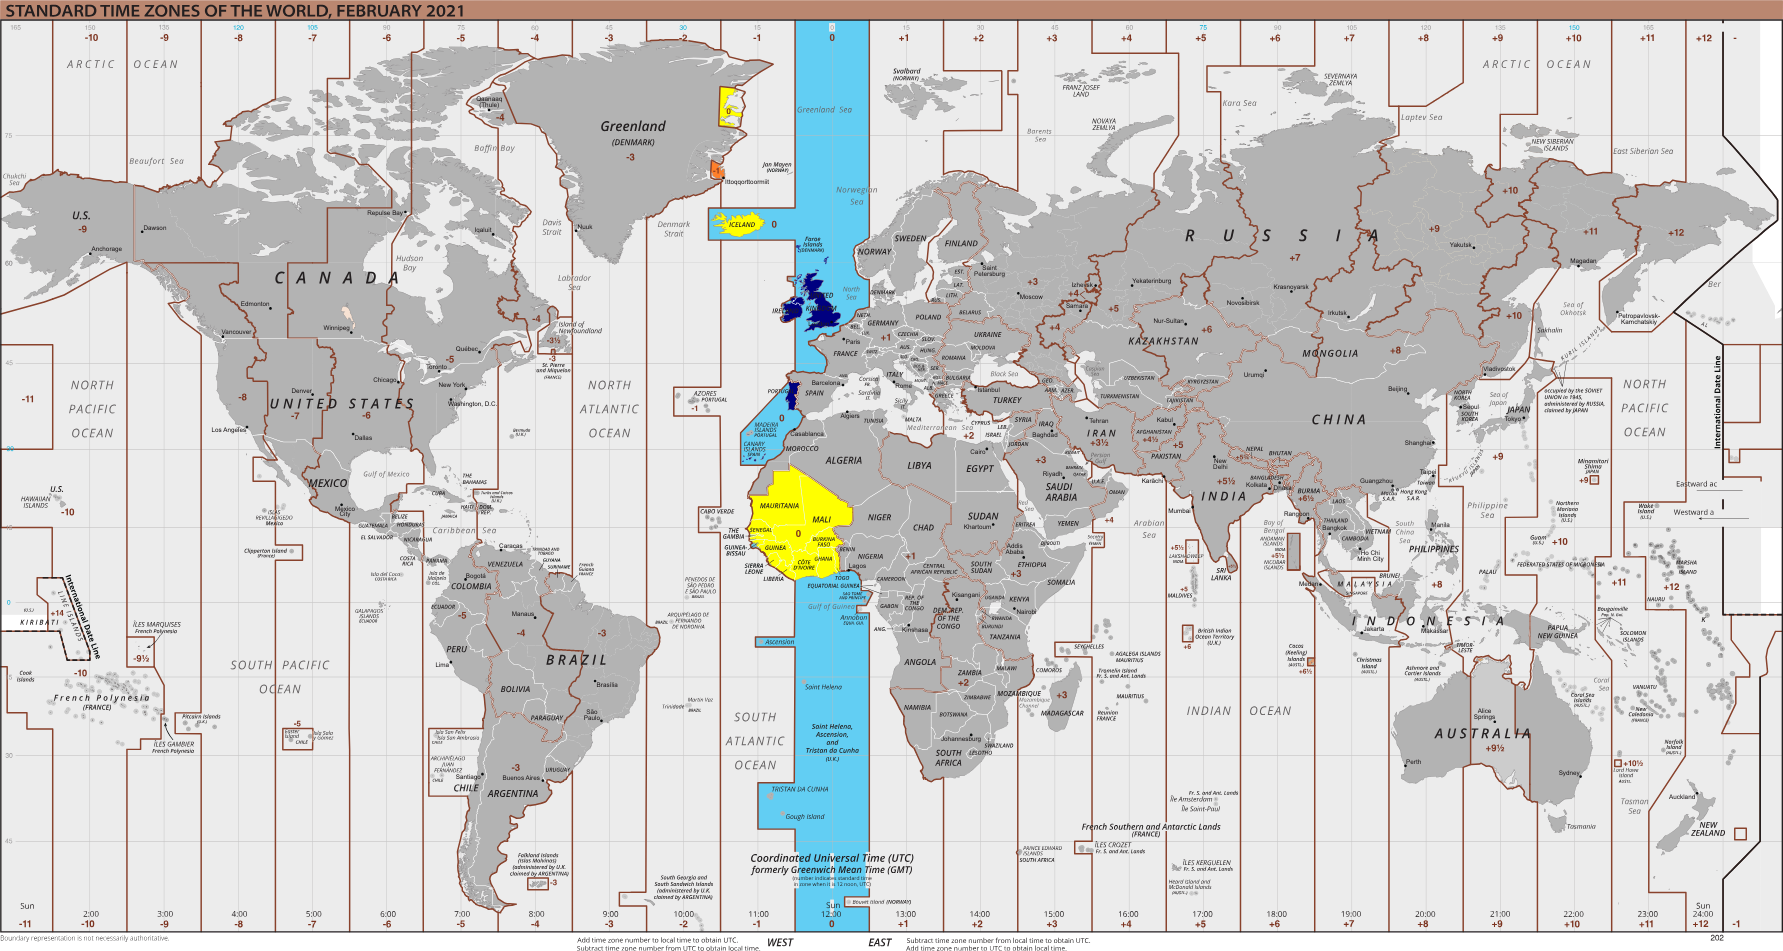![image.png]

# Example: Converting Coordinated Universal Time (UTC) to Local Time (LT)

This code example demonstrates how to convert data with Coordinated Universal Time (UTC) to a specific Local Time (LT) and select indices where the local time is within a specified range around a target time.

## Steps:

1. **Longitude Grid Data**:
   - A longitude grid ranging from -180 to 180 degrees is created with 1440 points. This grid represents different longitudes on Earth.

2. **Observed Time**:
   - The observed time is given in minutes since a reference time (`2000-01-01 03:00:00`). This is converted to a `datetime` object for easier manipulation.

3. **Convert Observed Minutes to Datetime**:
   - The observed minutes are added to the reference time to get the exact observed time in `datetime` format.

4. **Calculate Local Time for Each Longitude**:
   - A function `calculate_local_time` is defined to calculate the local time for a given longitude. It considers the time difference based on the longitude (since every 15 degrees of longitude corresponds to 1 hour difference from UTC).

5. **Generate Local Times Array**:
   - An array of local times is created for each longitude in the grid by applying the `calculate_local_time` function.

6. **Define Target Local Time**:
   - The target local time is set (e.g., 6 AM). The goal is to find longitudes where the local time is within ±1 hour of this target time.

7. **Select Indices Based on Local Time**:
   - The indices of longitudes where the local time is within the target time range (±1 hour) are selected using `numpy.where`. The condition checks for the local time to be within this range.

8. **Print Results**:
   - If there are any selected indices, the corresponding longitudes are printed. Otherwise, a message is printed indicating that no longitudes were found within the target time range.

## Key Points:

- **Time Conversion**: The code demonstrates how to convert a given UTC time to local times for different longitudes.
- **Time Range Selection**: It shows how to select specific longitudes based on a target local time and a specified range.
- **Use of NumPy and Datetime**: The code utilizes NumPy for efficient array operations and the `datetime` module for handling time calculations.

This example can be useful in applications where you need to analyze or visualize data based on local times across different geographic regions.


In [254]:
import sys
import os
import platform
import importlib
import glob

import pandas as pd
import numpy as np
from scipy.stats import genextreme
from scipy.stats import norm
import netCDF4
from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import pymannkendall as mk
from scipy.stats import ttest_ind, mannwhitneyu

if platform.system() == 'Darwin':  # macOS
    base_FP = '/Users/hyunglokkim/Insync/hkim@geol.sc.edu/Google_Drive'
    cpuserver_data_FP = '/Users/hyunglokkim/cpuserver_data'
else:
    base_FP = '/data'
    cpuserver_data_FP = '/data'
sys.path.append(base_FP + '/python_modules')

#hydroAI libs
import HydroAI.Data as hData
import HydroAI.Plot as hPlot
importlib.reload(hData);
importlib.reload(hPlot);

# Ignore runtime warnings
import warnings
warnings.filterwarnings("ignore")

In [228]:
## 1) You always first need to check what varibles exist in the data set
# Usage example with GLDAS; get the nc files
year = 2015
target_local_time = 6 # 6 am
GLDAS_FP = cpuserver_data_FP + '/GLDAS/hours3/'
nc_file_paths = hData.get_file_list(GLDAS_FP, 'nc4') # 1-1) understand what this code does

# check the variable names and their units
_,units,_ = hData.get_nc_variable_names_units(nc_file_paths[0]);

+-----------------------+------------------------------------+-----------------------------------+
| Name                  | Long Name                          | Units                             |
+=======================+====================================+===================================+
| time                  | time                               | minutes since 2000-01-01 03:00:00 |
+-----------------------+------------------------------------+-----------------------------------+
| time_bnds             |                                    |                                   |
+-----------------------+------------------------------------+-----------------------------------+
| lon                   | longitude                          | degrees_east                      |
+-----------------------+------------------------------------+-----------------------------------+
| lat                   | latitude                           | degrees_north                     |
+---------

In [89]:
# 2. Second, always check the data and map it
# 2-1) Load the data (soil moisture, latitude, and longitude)
sm_0_10 = hData.get_variable_from_nc(nc_file_paths[0], 'SoilMoi0_10cm_inst', layer_index=0, flip_data='False')
lat  = np.flipud(hData.get_variable_from_nc(nc_file_paths[0], 'lat', layer_index=0))
lon  = hData.get_variable_from_nc(nc_file_paths[0], 'lon', layer_index=0)
lon, lat = np.meshgrid(lon, lat)

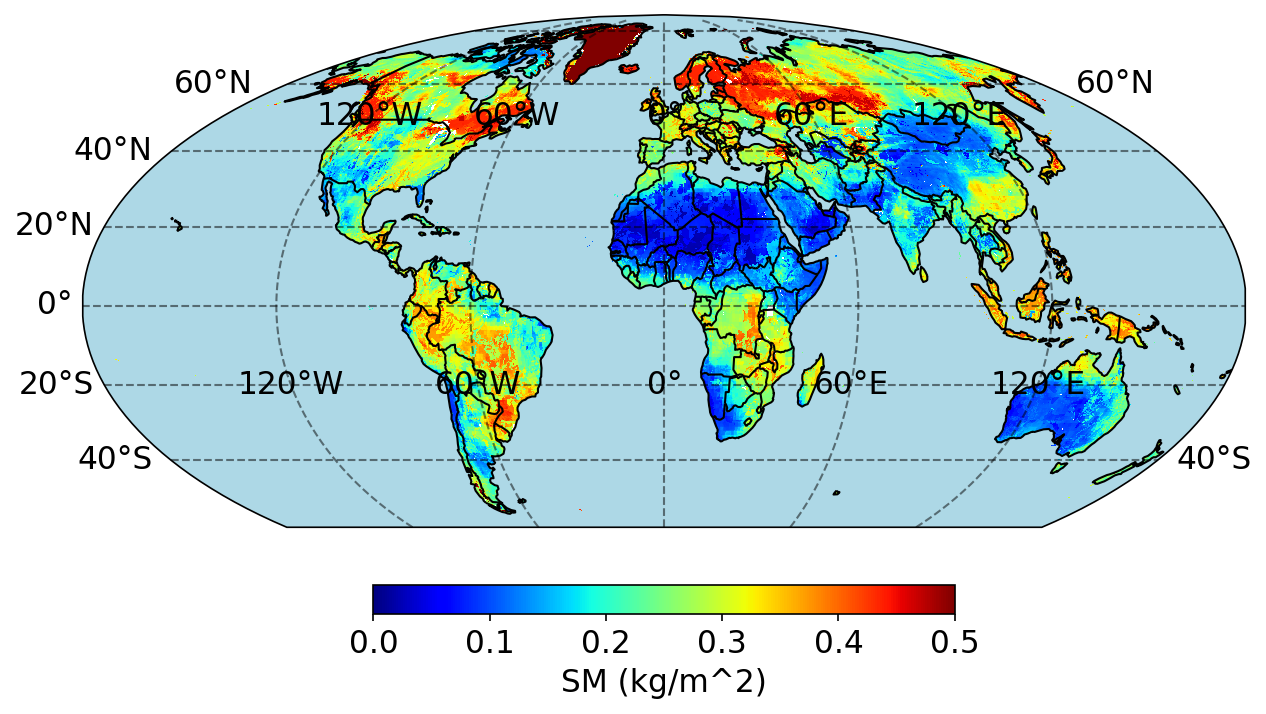

In [90]:
# 2-2) Map the loaded data
hPlot.plot_map(lon, lat, sm_0_10/100, 0, 0.5, plot_title='soil mositure (0-10 cm)', label_title='SM (kg/m^2)', cmap='jet');

In [240]:
# Function to calculate local time for a given longitude
def calculate_local_time(utc_time, longitude):
    # Calculate the time difference in hours
    time_difference = longitude / 15.0
    # Calculate local time
    local_time = utc_time + timedelta(hours=time_difference)
    return local_time

def doy_to_yearyyyymmdd(year, doy):
    # Create a date object for the first day of the given year
    start_date = datetime(year, 1, 1)
    # Add the DOY to the start date to get the correct date
    target_date = start_date + timedelta(days=doy - 1)
    # Format the output as yearmmdd
    formatted_date = target_date.strftime('%Y%m%d')
    return formatted_date

In [243]:
reference_time = datetime(2000, 1, 1, 3, 0, 0)

UTC_time = hData.get_variable_from_nc(nc_file_paths[0], 'time', layer_index=0, flip_data='False')
# Convert observed minutes to a datetime object
UTC_time = reference_time + timedelta(minutes=UTC_time[0])

print('The UTC time of the current file is', UTC_time)

The UTC time of the current file is 2015-01-01 00:00:00


In [244]:
# Array to store local times
local_times = np.array([calculate_local_time(UTC_time, lon) for lon in lon[0,:]])
# Select areas where local time is target local time (e.g., 6 AM)
selected_indices = np.where([(lt.hour == target_local_time) for lt in local_times])[0]

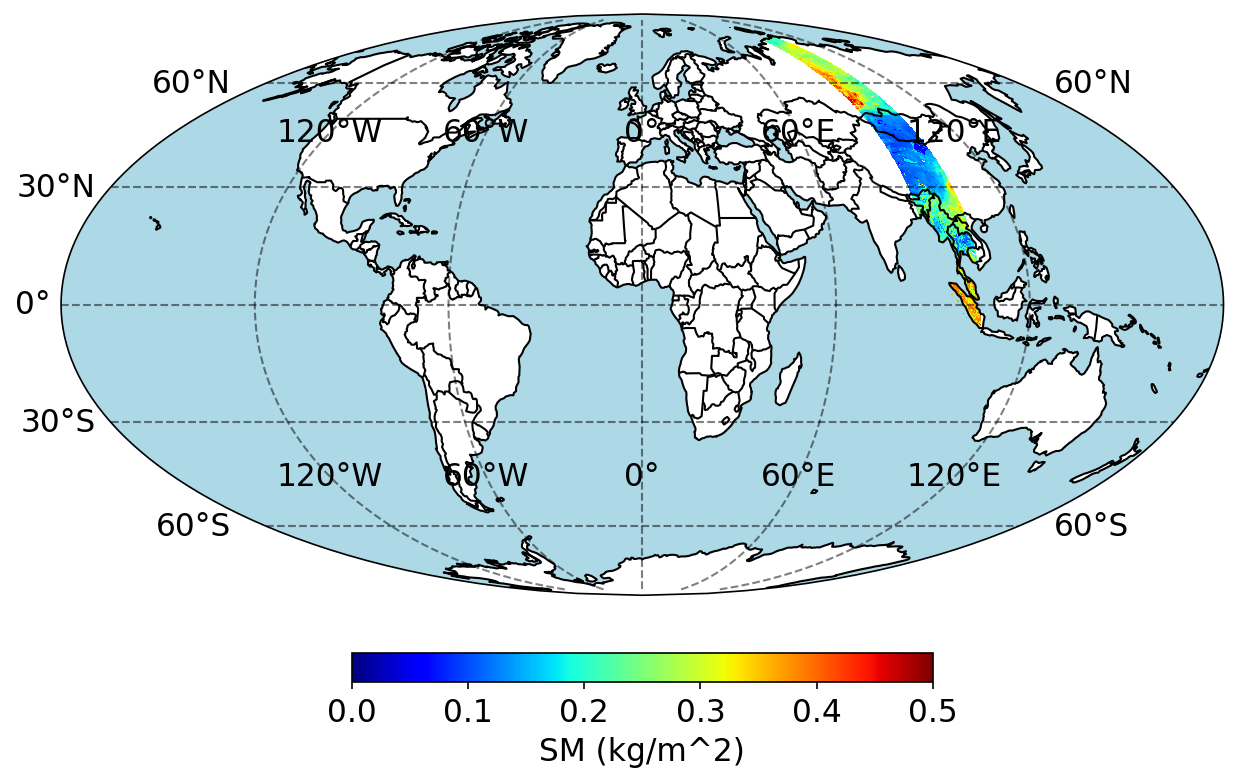

In [245]:
# 2-4) when UTC is given with above UTC_time, the areas where the local time 6:00 - 6:59 is shown below:
hPlot.plot_map(lon[:, selected_indices], lat[:, selected_indices], sm_0_10[:, selected_indices]/100, 0, 0.5, plot_title='soil mositure (0-10 cm)', label_title='SM (kg/m^2)', cmap='jet', bounds='global');

UTC time is  2015-01-01 00:00:00
The areas wehre the local time is  6


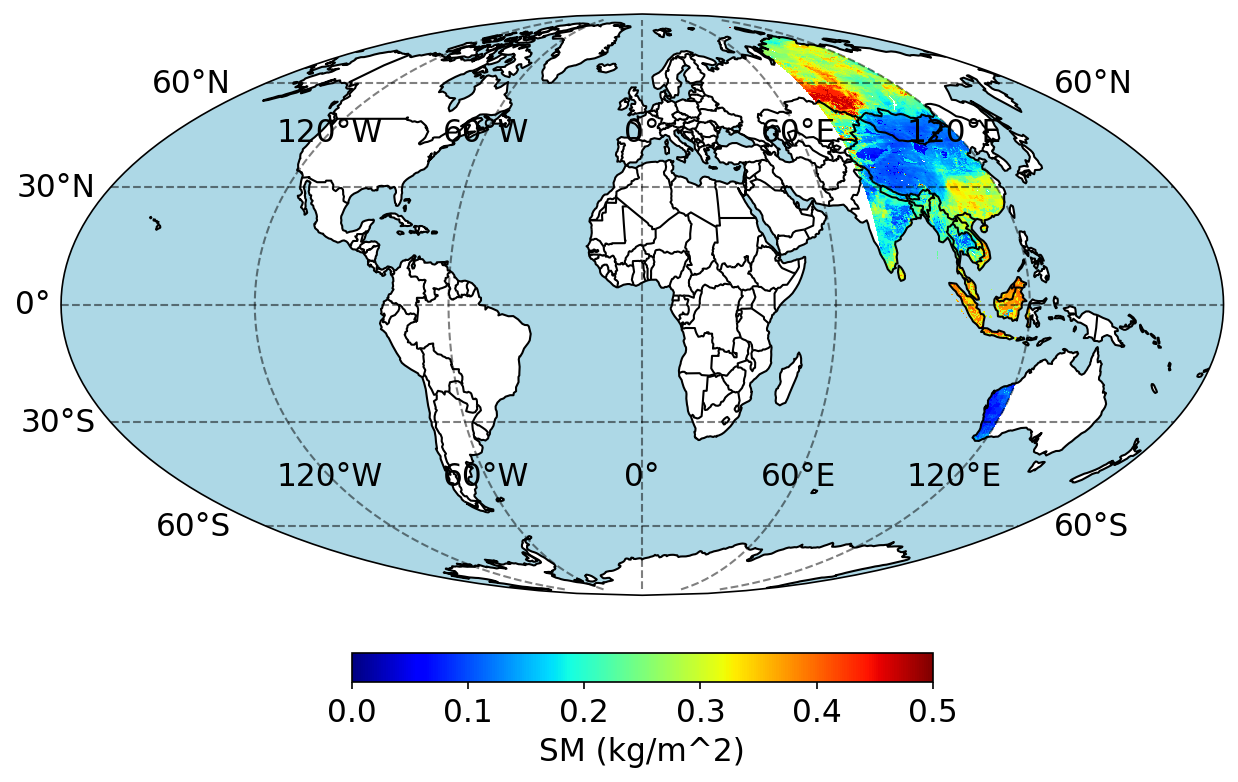

UTC time is  2015-01-01 03:00:00
The areas wehre the local time is  6


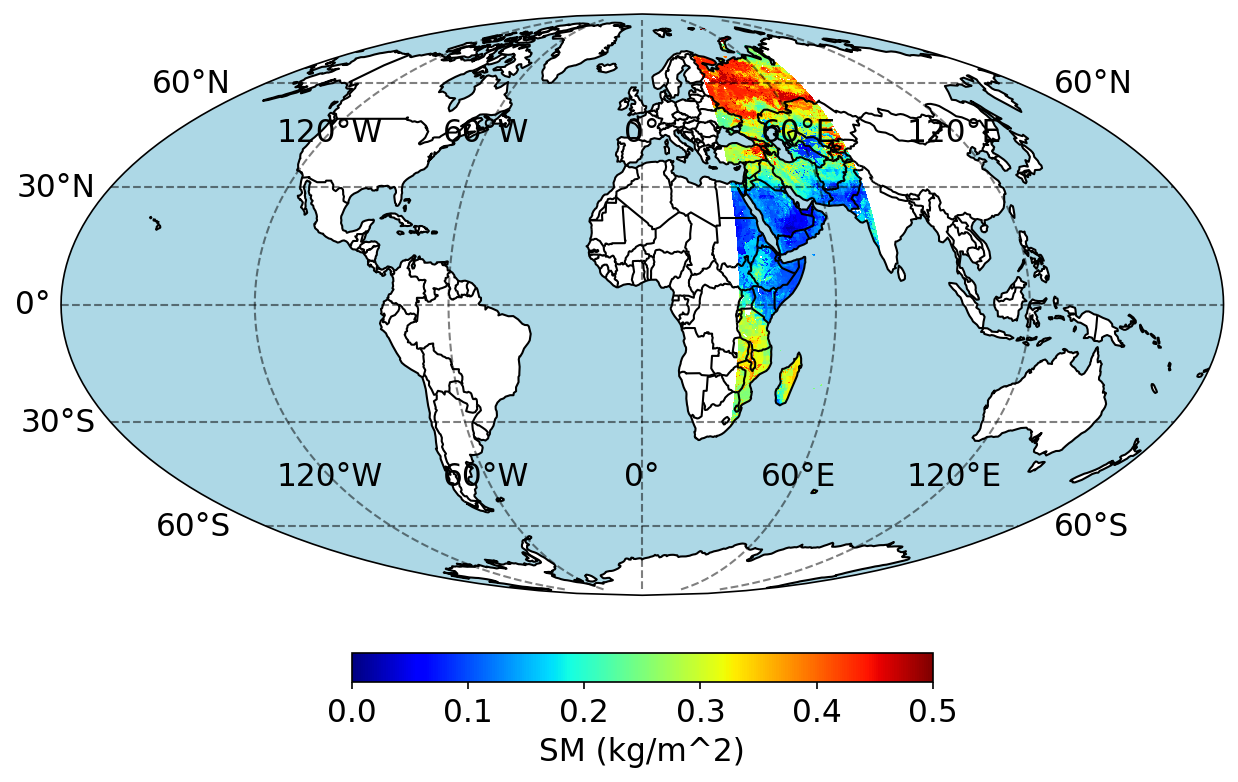

UTC time is  2015-01-01 06:00:00
The areas wehre the local time is  6


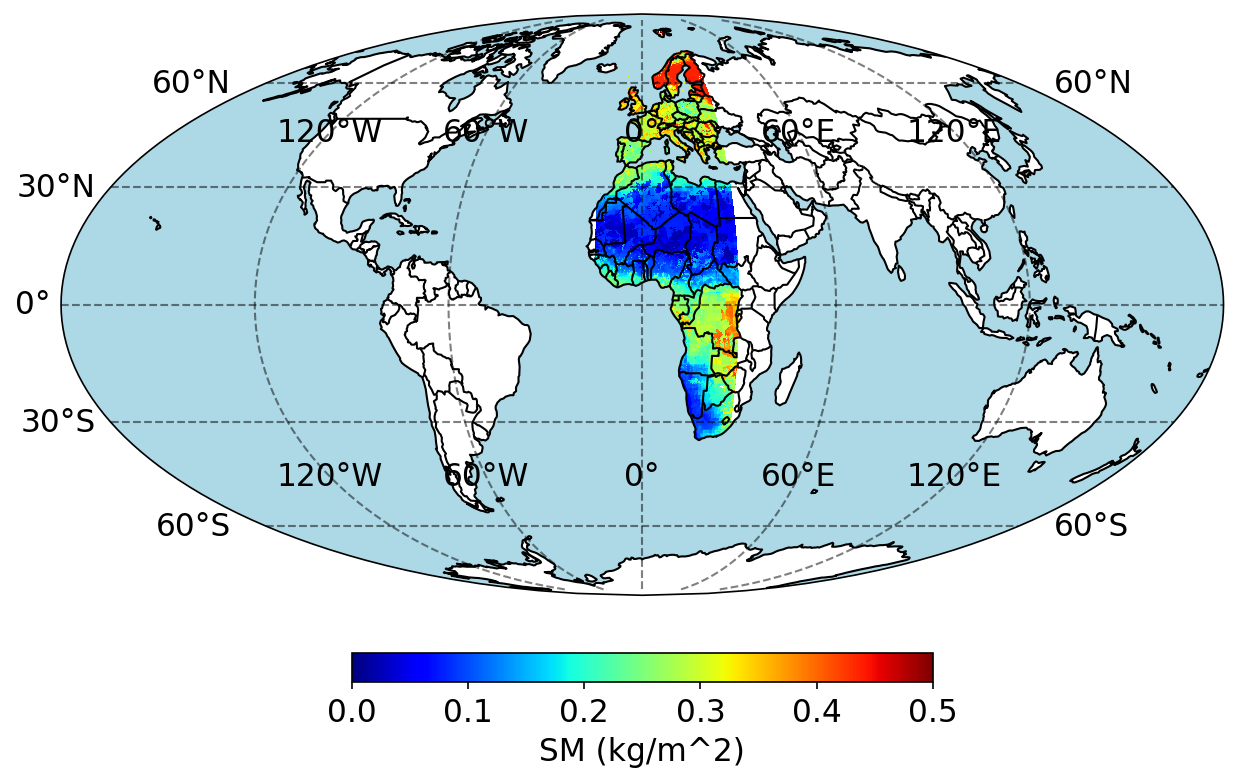

UTC time is  2015-01-01 09:00:00
The areas wehre the local time is  6


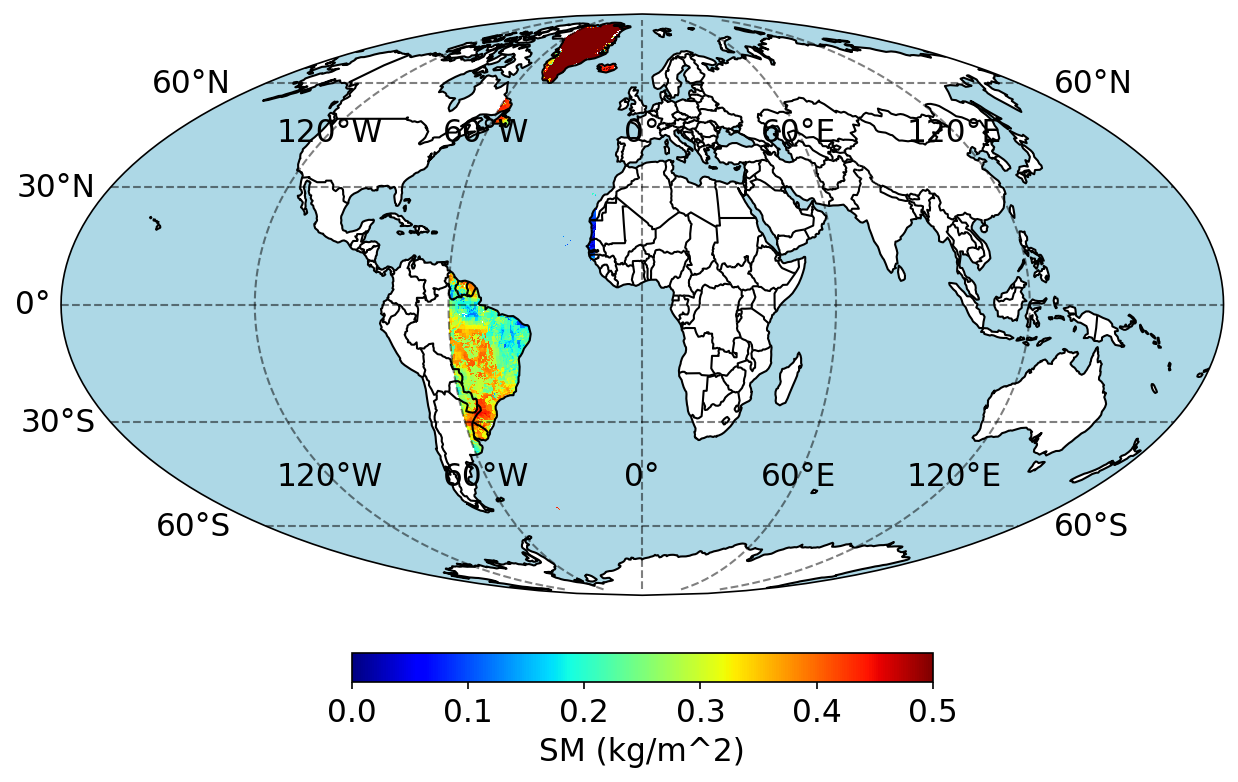

UTC time is  2015-01-01 12:00:00
The areas wehre the local time is  6


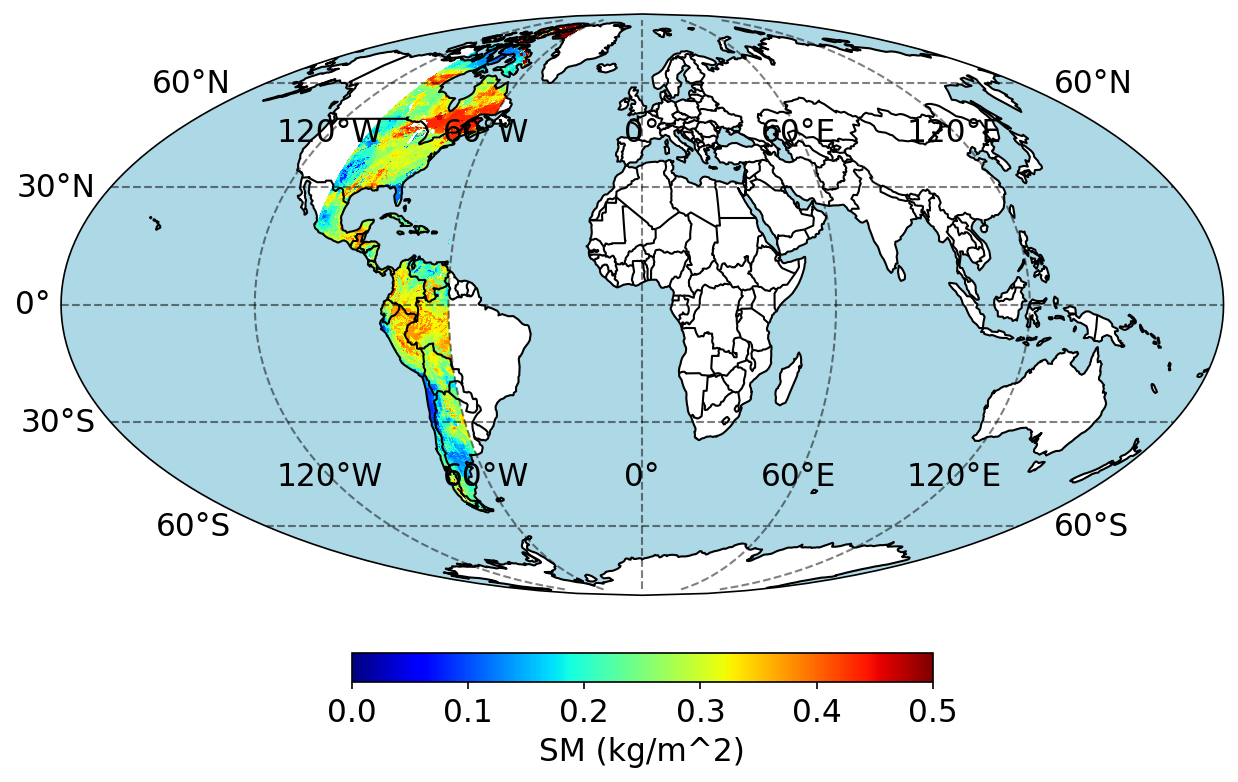

UTC time is  2015-01-01 15:00:00
The areas wehre the local time is  6


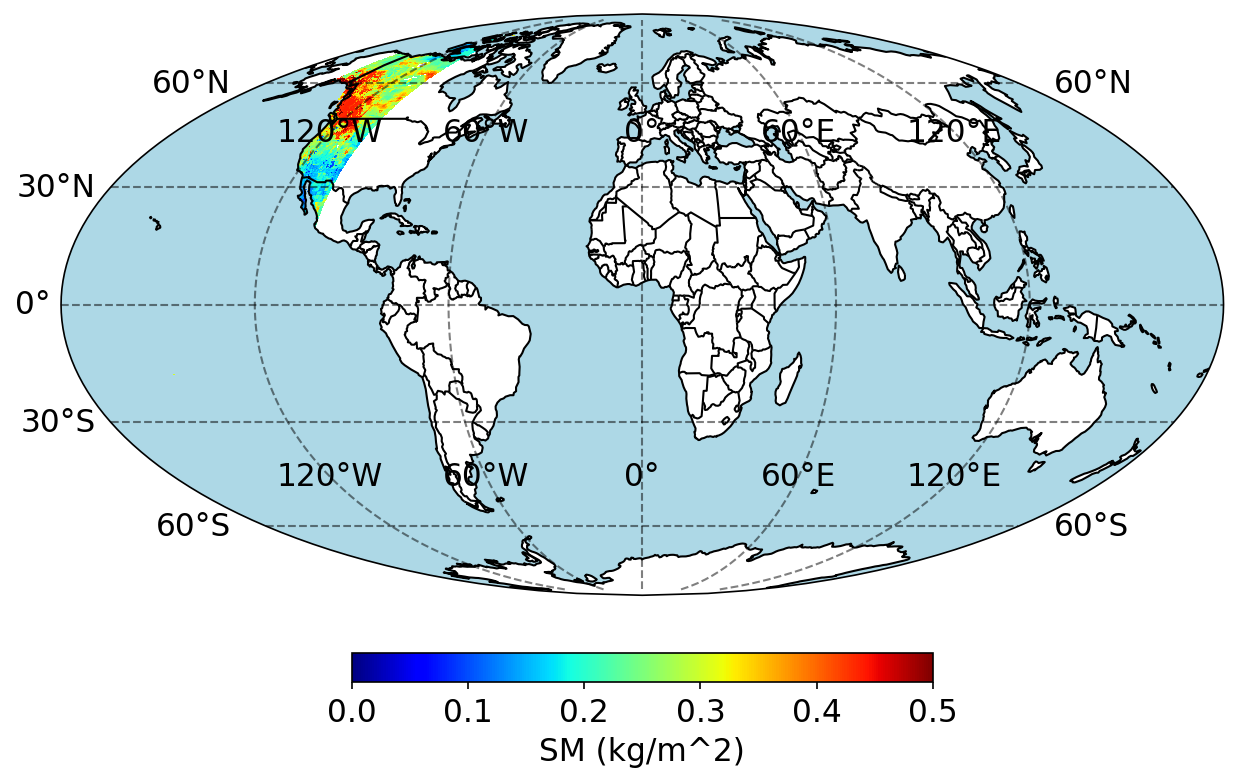

UTC time is  2015-01-01 18:00:00
The areas wehre the local time is  6


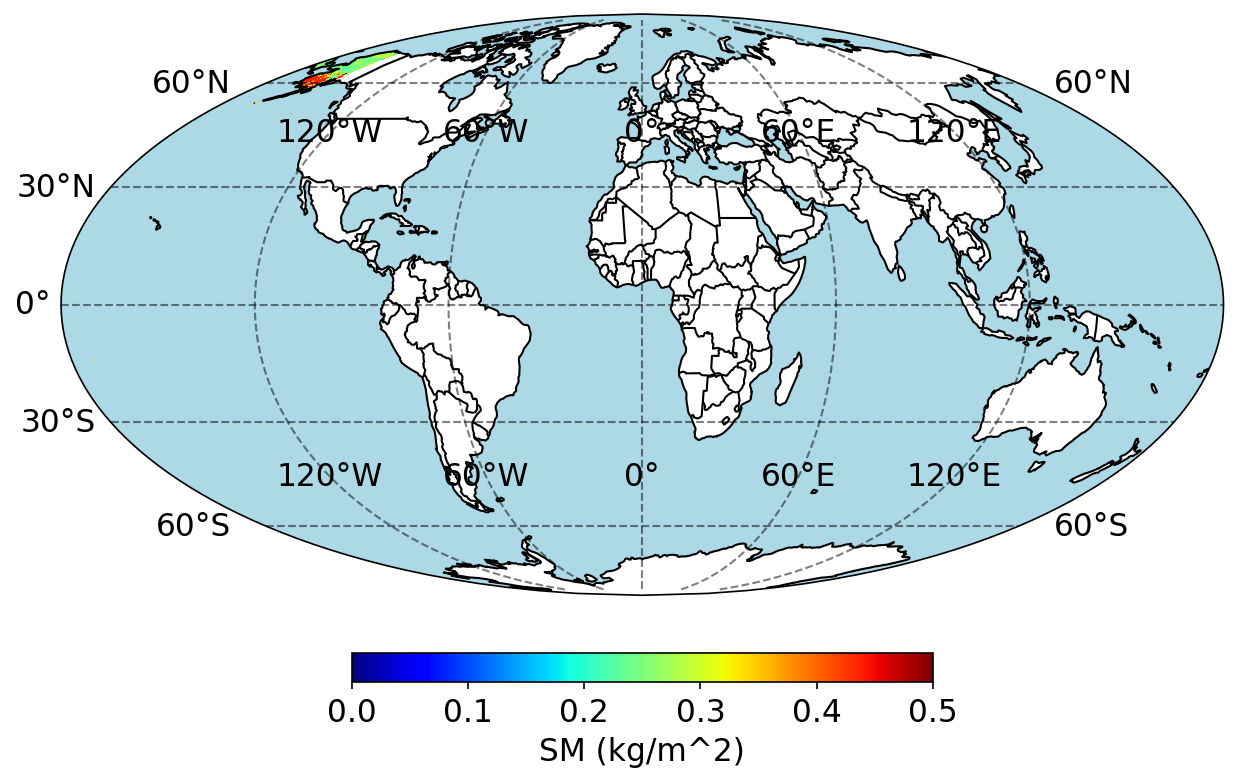

In [220]:
# 2-3) scan all the nc files that include target doy and local time
t_doy = 1
t_nc_file_paths = hData.get_file_list(GLDAS_FP, 'nc4', filter_strs=[doy_to_yearyyyymmdd(year, t_doy-1), doy_to_yearyyyymmdd(year, t_doy), doy_to_yearyyyymmdd(year, t_doy+1)]) 
for i in t_nc_file_paths:
    t_sm_0_10 = hData.get_variable_from_nc(i, 'SoilMoi0_10cm_inst', layer_index=0, flip_data='False')
    t_UTC_time = hData.get_variable_from_nc(i, 'time', layer_index=0, flip_data='False')
    # Convert observed minutes to a datetime object
    t_UTC_time = reference_time + timedelta(minutes=t_UTC_time[0])
    t_local_times = np.array([calculate_local_time(t_UTC_time, lon) for lon in lon[0,:]])
    # Select areas where local time is target local time (e.g., 6 AM)
    #t_selected_indices = np.where([(lt.year == 2015) & (lt.day == int(doy_to_yearyyyymmdd(year, 1)[7:8])) & (lt.hour == target_local_time) for lt in t_local_times])[0]
    t_selected_indices = np.where([(lt.year == year) & (lt.day == int(doy_to_yearyyyymmdd(year, t_doy)[7:8])) & (target_local_time - 1 <= lt.hour <= target_local_time + 1) for lt in t_local_times])[0]

    if t_selected_indices.size>0:
        print('UTC time is ', t_UTC_time)
        print('The areas wehre the local time is ', target_local_time)
        hPlot.plot_map(lon[:, t_selected_indices], lat[:, t_selected_indices], t_sm_0_10[:, t_selected_indices]/100, 0, 0.5, plot_title='soil mositure (0-10 cm)', label_title='SM (kg/m^2)', cmap='jet', bounds='global');

20160104 at  6  local time.


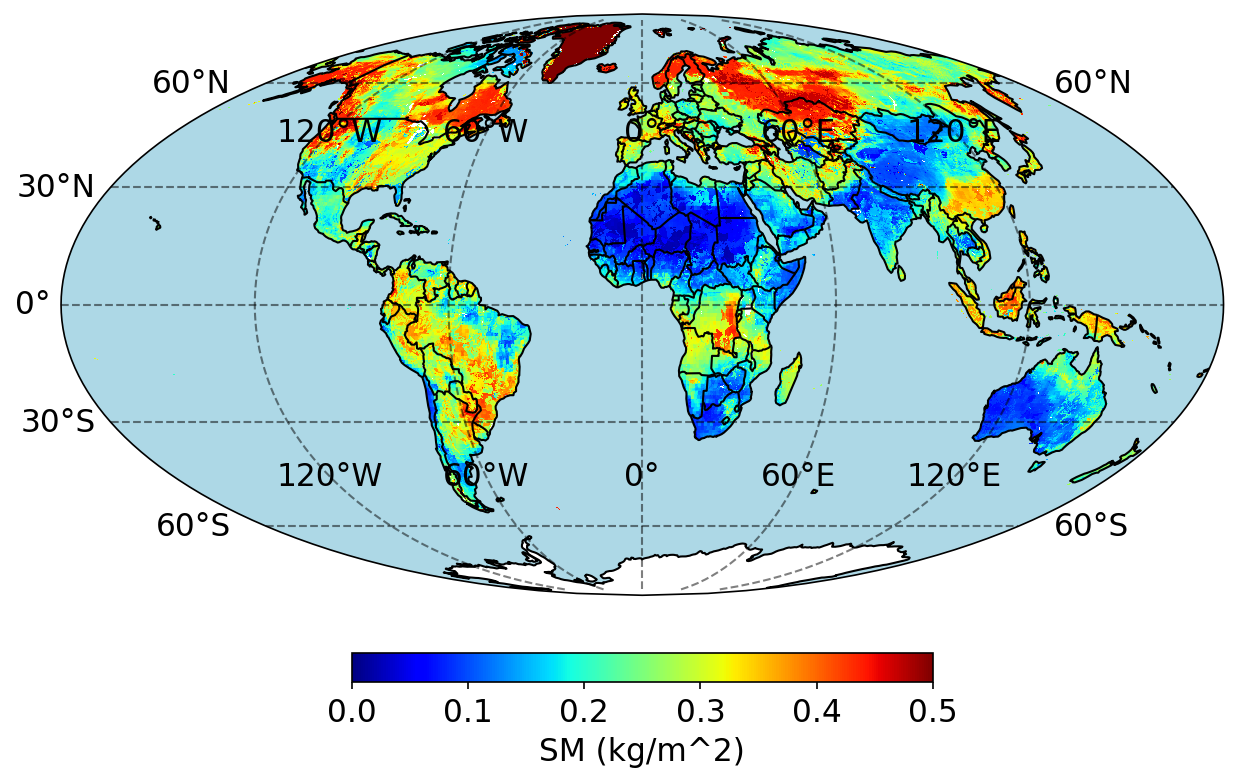

In [246]:
# 2-4) Combined the areas where target doy and time exist
t_doy = 4
t_nc_file_paths = hData.get_file_list(GLDAS_FP, 'nc4', filter_strs=[doy_to_yearyyyymmdd(year, t_doy-1), doy_to_yearyyyymmdd(year, t_doy), doy_to_yearyyyymmdd(year, t_doy+1)])
t_sm_0_10_LT_combined = np.full((lat.shape), np.nan)

for i in t_nc_file_paths:
    t_sm_0_10 = hData.get_variable_from_nc(i, 'SoilMoi0_10cm_inst', layer_index=0, flip_data='False')
    t_UTC_time = hData.get_variable_from_nc(i, 'time', layer_index=0, flip_data='False')
    # Convert observed minutes to a datetime object
    t_UTC_time = reference_time + timedelta(minutes=t_UTC_time[0])
    t_local_times = np.array([calculate_local_time(t_UTC_time, lon) for lon in lon[0,:]])
    # Select areas where local time is target local time (e.g., 6 AM)
    t_selected_indices = np.where([(lt.year == year) & (lt.day == int(doy_to_yearyyyymmdd(year, t_doy)[7:8])) & (target_local_time - 1 <= lt.hour <= target_local_time + 1) for lt in t_local_times])[0]

    if t_selected_indices.size>0:
        t_sm_0_10_LT_combined[:, t_selected_indices] = t_sm_0_10[:, t_selected_indices]

print(doy_to_yearyyyymmdd(year, t_doy), 'at ', target_local_time ,' local time.')
hPlot.plot_map(lon, lat, t_sm_0_10_LT_combined/100, 0, 0.5, plot_title='soil mositure (0-10 cm)', label_title='SM (kg/m^2)', cmap='jet', bounds='global');

20160101 at  6  local time.


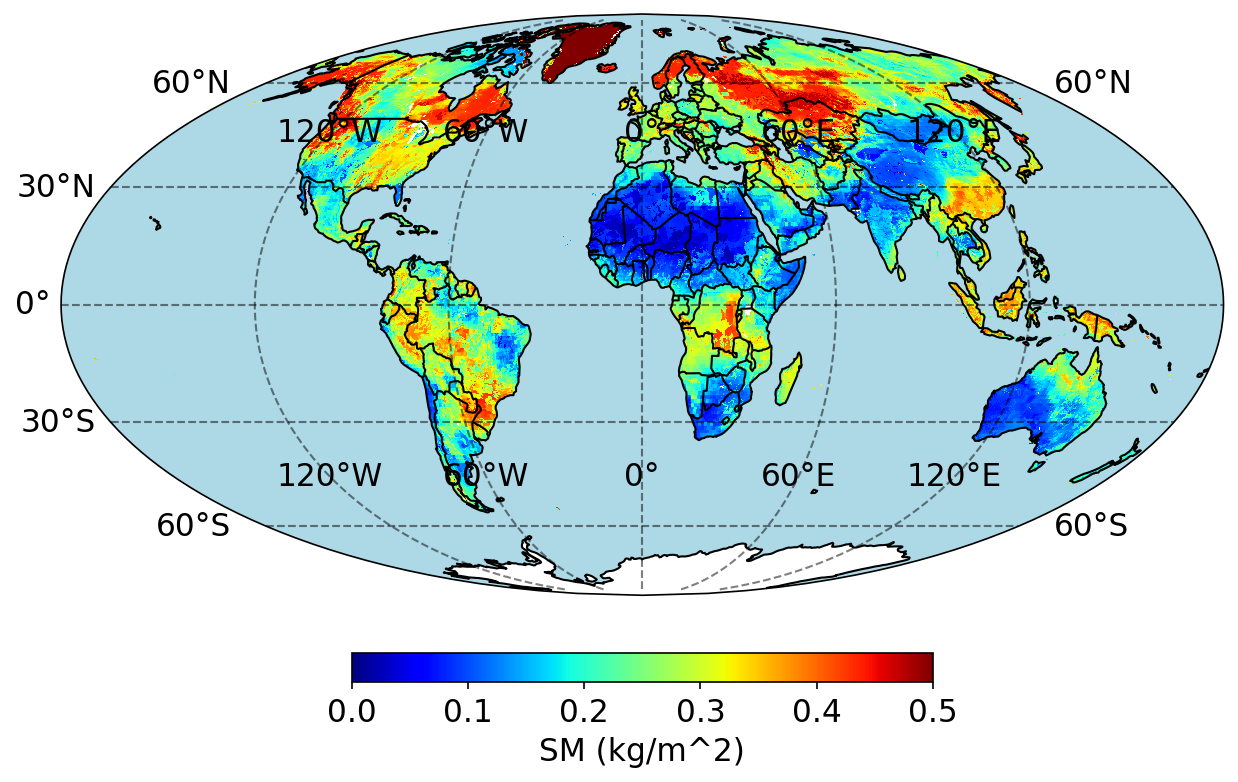

In [250]:
# 2-5) Create an unit function
def UTC_to_LT(data_FP, target_local_time, lon, year, doy, var_name, layer_index=0):
    reference_time = datetime(2000, 1, 1, 3, 0, 0)
    t_nc_file_paths = hData.get_file_list(data_FP, 'nc4', filter_strs=[doy_to_yearyyyymmdd(year, doy-1), doy_to_yearyyyymmdd(year, doy), doy_to_yearyyyymmdd(year, doy+1)])
    t_var_LT_combined = np.full((lon.shape), np.nan)
    
    for i in t_nc_file_paths:
        t_var = hData.get_variable_from_nc(i, var_name, layer_index=layer_index, flip_data='False')
        t_UTC_time = hData.get_variable_from_nc(i, 'time', layer_index=0, flip_data='False')
        
        # Convert observed minutes to a datetime object
        t_UTC_time = reference_time + timedelta(minutes=t_UTC_time[0])
        t_local_times = np.array([calculate_local_time(t_UTC_time, lon) for lon in lon[0,:]])
        # Select areas where local time is target local time (e.g., 6 AM)
        t_selected_indices = np.where([(lt.year == year) & (lt.day == int(doy_to_yearyyyymmdd(year, doy)[7:8])) & (target_local_time - 1 <= lt.hour <= target_local_time + 1) for lt in t_local_times])[0]
    
        if t_selected_indices.size>0:
            t_var_LT_combined[:, t_selected_indices] = t_var[:, t_selected_indices]
    print(doy_to_yearyyyymmdd(year, doy), 'at ', target_local_time ,' local time.')

    return t_var_LT_combined

doy = 1
t_var_LT_combined=UTC_to_LT(GLDAS_FP, target_local_time, year, doy, 'SoilMoi0_10cm_inst')
hPlot.plot_map(lon, lat, t_var_LT_combined/100, 0, 0.5, plot_title='soil mositure (0-10 cm)', label_title='SM (kg/m^2)', cmap='jet', bounds='global');

In [255]:
# 3. HydroAI Library implementation
t_var_LT_combined=hData.UTC_to_LT(GLDAS_FP, target_local_time, lon, year, doy, 'SoilMoi0_10cm_inst')

NameError: name 'lat' is not defined